<a href="https://colab.research.google.com/github/ShivaHariSonu/dlproject/blob/main/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [ ]:
!pip install gensim

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import tensorflow



import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer


from gensim.models import Word2Vec


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import plotly.express as px

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [ ]:
plt.style.use('ggplot')

# Loading the Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/DeepLearningProject/test_set.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df = pd.read_csv('/content/drive/MyDrive/DeepLearningProject/train_set.csv', encoding = "UTF-8", encoding_errors='ignore')

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
train_df.info() # Basic Information
print("\nShape: ",train_df.shape) # Shape of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB

Shape:  (41157, 6)


In [ ]:
print("\nChecking for missing values in training data")
train_df.isnull().sum()# Check for missing values


Checking for missing values in training data


UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
print("\nChecking for missing values in test data")
test_df.isna().sum()


Checking for missing values in test data


UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [ ]:
#Dropping unnecessary columns in test and training data frames
train_df.drop(['Location','ScreenName','UserName','TweetAt'],axis=1,inplace=True)
test_df.drop(['Location','ScreenName','UserName','TweetAt'],axis=1,inplace=True)

In [ ]:
train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
print(" No. of values of the sentiment present: \n",train_df.Sentiment.value_counts())

 No. of values of the sentiment present: 
 Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


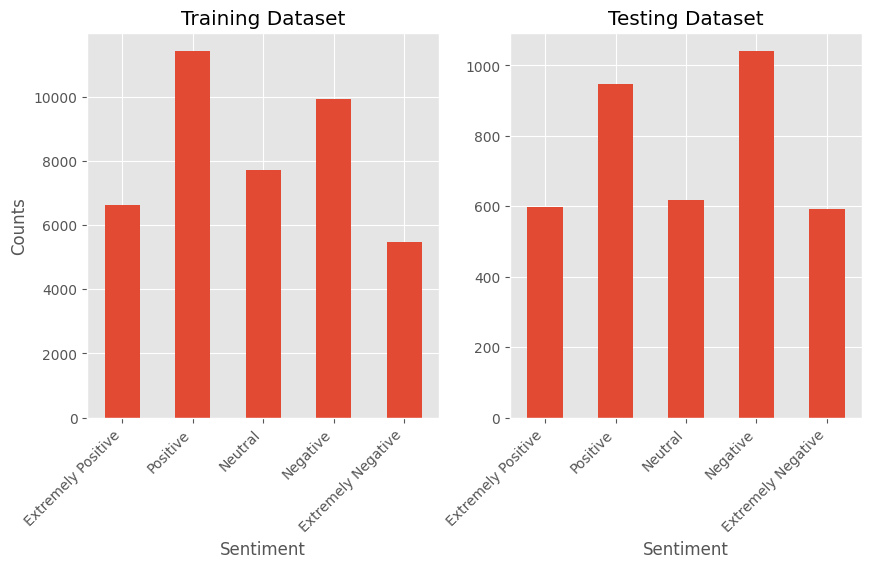

In [ ]:
#Visualising the datasets plotted
reorder = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')

test_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset');

In [ ]:

# For training set visualising the distribution of the data
fig=px.histogram(train_df,
                x='Sentiment',
                title='Sentiment Count ',
                color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()
fig = px.pie(train_df, names='Sentiment',title="Sentiment Distribution")
fig.show()

**What can we say from the above plot?**

*  From the above plot we can infer that Maximum tweets are inferred with the positive followed by the negative tweets.
*  We can observe that the percentages of the positive and negative tweets are almost similar in the distribution




#Merging the Extremely positive tweets as Positive and the Extremely negative tweets as negative.

Earlier I have tried with having five attributes of (Extremely Positive, Positive, Extremely Negative, Negative and Neutral) and it resulted in the accuracy of 34 percent on Naive Bayes. Results have been demonstrated in the Project Milestone paper.

The authors of the
paper considered combining the target classes (https://rdcu.be/dsLjy). The
aim is to classify the data into three categories led to
merging the extremely negative and negative tweets in the
same class, while the same happened for the data belonging to the extremely positive and positive class, respectively.



In [ ]:
#Merging data columns Extremely Neagtive Sentiment as Negative and Extremely Positive Sentiment as Positive.
def merge(df):
    df['Sentiment'].replace(to_replace='Extremely Negative',value='Negative',inplace=True)
    df['Sentiment'].replace(to_replace='Extremely Positive',value='Positive',inplace=True)
merge(train_df)
merge(test_df)

In [ ]:
print(" No. of values of the sentiment present: \n",train_df.Sentiment.value_counts())

 No. of values of the sentiment present: 
 Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64


In [ ]:
fig = px.pie(train_df, names='Sentiment',title="Sentiment Distribution")
fig.show()

Here we can observe that the positive tweets are still dominant when compared to the negative tweets.

# Data Preprocessing

In [ ]:
##Function to extract the tweet length
def tweet_length(tweet):
    str_len=len(tweet.split(" "))
    return(str_len)
train_df['OriginalLength']= train_df['OriginalTweet'].apply(lambda x:tweet_length(x))
train_df.head()

,OriginalTweet,Sentiment,OriginalLength
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8
1,advice Talk to your neighbours family to excha...,Positive,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,14
3,My food stock is not the only one which is emp...,Positive,40
4,"Me, ready to go at supermarket during the #COV...",Negative,38


In [ ]:
print("The maximum word length count of a tweet is", train_df['OriginalLength'].max())

The maximum word length count of a tweet is 127


In [ ]:
# Observing the tweets structure

#Modifying the range to be flexible in understanding the tweets
for i in range (5):
    print(train_df.OriginalTweet[i])
    print("========================================")

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n


We can observe that the tweets has links and other information which are not relevant in the context of sentiment analysis. Need to perform preprocessing to increase the accuracy in the sentiment analysis.

In [ ]:
train_df['OriginalLength'].describe()

count    41157.000000
mean        30.327818
std         11.633754
min          1.000000
25%         21.000000
50%         31.000000
75%         40.000000
max        127.000000
Name: OriginalLength, dtype: float64

In [ ]:
fig = px.histogram(train_df,
                  x='OriginalLength',
                  marginal='box',
                  title="Length of original tweets")
fig.update_layout(bargap=0.1)
fig.show()

We can observe that the tweets normal distribution is skewed towards right. Also another observation is that it has outliers and the maximum value is of 127. Need can perform better preprocessing so that the box plot can have the maximum value upto 80 and doesn't have any outliers.

**Irrelevant Information**

*   Links, URLS
*   StopWords
*   Symbols
*   Numbers





In [ ]:
# Cleaning the Responses
def clean_responses(data):
    cleaned_responses = []
    fillerwords = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't"]
    for i in remove:
        stop_words.discard(i)
    stop_words.add(fillerwords)

    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])#extracting hashtags
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)#extracting links
        html=   re.compile(r'<.*?>')#extracting html tags
        tweet =html.sub(r"", tweet)
        #extracting symbols and characters
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet)
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet)
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_responses.append(tweet)
    return cleaned_responses

In [ ]:
####Preprocessing and cleaning train data
text_to_list=train_df['OriginalTweet'].tolist()
process_text=clean_responses(text_to_list)

cleaned_tweet =pd.DataFrame(process_text)
train_df['CleanedTweet']=cleaned_tweet
#cleaned_tweet.head()


train_df.head()

,OriginalTweet,Sentiment,OriginalLength,CleanedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,
1,advice Talk to your neighbours family to excha...,Positive,38,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,40,food stock not one empty please dont panic eno...
4,"Me, ready to go at supermarket during the #COV...",Negative,38,ready go supermarket covid outbreak not im par...


In [ ]:
####Preprocessing and cleaning test data
test_df['OriginalLength']= test_df['OriginalTweet'].apply(lambda x:tweet_length(x))


texto_data=test_df['OriginalTweet'].tolist()
process_text=clean_responses(texto_data)
cleaned_tweet =pd.DataFrame(process_text)
test_df['CleanedTweet']=cleaned_tweet
#cleaned_tweet.head()
test_df.head()

,OriginalTweet,Sentiment,OriginalLength,CleanedTweet
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31,couldnt find hand sanitizer fred meyer turned ...
2,Find out how you can protect yourself and love...,Positive,13,find protect loved one coronavirus
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35,panic buying hit newyork city anxious shopper ...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,30,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
#Adding length of cleaned tweet to dataset
train_df['CleanedTweetLength']= train_df['CleanedTweet'].apply(lambda x:tweet_length(x))
test_df['CleanedTweetLength']= test_df['CleanedTweet'].apply(lambda x:tweet_length(x))

In [ ]:
train_df.head()

,OriginalTweet,Sentiment,OriginalLength,CleanedTweet,CleanedTweetLength
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,,1
1,advice Talk to your neighbours family to excha...,Positive,38,advice talk neighbour family exchange phone nu...,28
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,coronavirus australia woolworth give elderly d...,12
3,My food stock is not the only one which is emp...,Positive,40,food stock not one empty please dont panic eno...,25
4,"Me, ready to go at supermarket during the #COV...",Negative,38,ready go supermarket covid outbreak not im par...,24


In [ ]:
test_df.head()

,OriginalTweet,Sentiment,OriginalLength,CleanedTweet,CleanedTweetLength
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23,trending new yorkers encounter empty supermark...,18
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31,couldnt find hand sanitizer fred meyer turned ...,14
2,Find out how you can protect yourself and love...,Positive,13,find protect loved one coronavirus,5
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35,panic buying hit newyork city anxious shopper ...,26
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,30,toiletpaper dunnypaper coronavirus coronavirus...,23


In [ ]:
print(train_df.CleanedTweetLength.describe())
fig = px.histogram(train_df,
                  x='CleanedTweetLength',
                  marginal='box',
                  title="Length of cleaned tweets",
                  color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()

count    41157.000000
mean        17.667639
std          6.632731
min          1.000000
25%         13.000000
50%         18.000000
75%         23.000000
max         40.000000
Name: CleanedTweetLength, dtype: float64


After preprocessing we can observe that the range changed to 0-40 and the outliers are decreased

**Label Encoding of the Categorical Response**

In [ ]:
le = LabelEncoder()
train_df['Sentiment_label'] = le.fit_transform(train_df['Sentiment'])
test_df['Sentiment_label'] = le.transform(test_df['Sentiment'])

In [ ]:
train_df.head()

,OriginalTweet,Sentiment,OriginalLength,CleanedTweet,CleanedTweetLength,Sentiment_label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,,1,1
1,advice Talk to your neighbours family to excha...,Positive,38,advice talk neighbour family exchange phone nu...,28,2
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,coronavirus australia woolworth give elderly d...,12,2
3,My food stock is not the only one which is emp...,Positive,40,food stock not one empty please dont panic eno...,25,2
4,"Me, ready to go at supermarket during the #COV...",Negative,38,ready go supermarket covid outbreak not im par...,24,0


In [ ]:
label_dict = (test_df[['Sentiment','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Sentiment']
              .to_dict())

for i, j in label_dict.items():
    print(i, j)

0 Negative
1 Neutral
2 Positive


In [ ]:
x_train = train_df.CleanedTweet
y_train = train_df.Sentiment_label

print(f"{len(x_train)} training examples")

41157 training examples


In [ ]:
x_test = test_df['CleanedTweet']
y_test = test_df['Sentiment_label']
print(f"{len(x_test)} testing examples")

3798 testing examples


In [ ]:
x_test.head()

0    trending new yorkers encounter empty supermark...
1    couldnt find hand sanitizer fred meyer turned ...
2                   find protect loved one coronavirus
3    panic buying hit newyork city anxious shopper ...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: CleanedTweet, dtype: object

In [ ]:
y_test.head()

0    0
1    2
2    2
3    0
4    1
Name: Sentiment_label, dtype: int64

# Model Training

**Converting the training data to Count Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(max_features= 3000, min_df = 3, max_df = 0.6)
# fit the model for training data
x_train_data = vectorizer.fit_transform(x_train)
x_train_data.shape

(41157, 3000)

In [ ]:
x_test_data = vectorizer.fit_transform(x_test)

In [ ]:
x_test_data.shape

(3798, 3000)

**Using Tf-Idf Vectorizer**

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
transformer = TfidfTransformer()
x_train_data = transformer.fit_transform(x_train_data).toarray()

print(x_train_data.shape)

(41157, 3000)


In [ ]:
x_test_data = transformer.fit_transform(x_test_data).toarray()
# print(x_train_data.shape)

In [ ]:
print(x_test_data.shape)

(3798, 3000)


In [ ]:
x_test_data[1]

array([0., 0., 0., ..., 0., 0., 0.])

#Naive Bayes Multinomial Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import train_test_split
x_train_NB, x_val_NB, y_train_NB, y_val_NB = train_test_split(x_train_data, y_train, test_size=0.33,random_state = 15)

In [ ]:
model1_nb = MultinomialNB()
y_train_pred = model1_nb.fit(x_train_NB,y_train_NB).predict(x_train_NB)

y_val_pred = model1_nb.predict(x_val_NB)

# comparing actual response values  with predicted response values
from sklearn import metrics
print("Multinomial Naive Bayes model train accuracy(in %):", metrics.accuracy_score(y_train_NB, y_train_pred)*100)
print("Multinomial Naive Bayes model validation accuracy(in %):", metrics.accuracy_score(y_val_NB, y_val_pred)*100)

Multinomial Naive Bayes model train accuracy(in %): 70.82139619220308
Multinomial Naive Bayes model validation accuracy(in %): 66.57340597850096


In [ ]:
y_test_pred = model1_nb.predict(x_test_data)
print("Multinomial Naive Bayes model test accuracy(in %):", metrics.accuracy_score(y_test, y_test_pred)*100)

Multinomial Naive Bayes model test accuracy(in %): 39.59978936282254


Accuracy: 0.3959978936282254


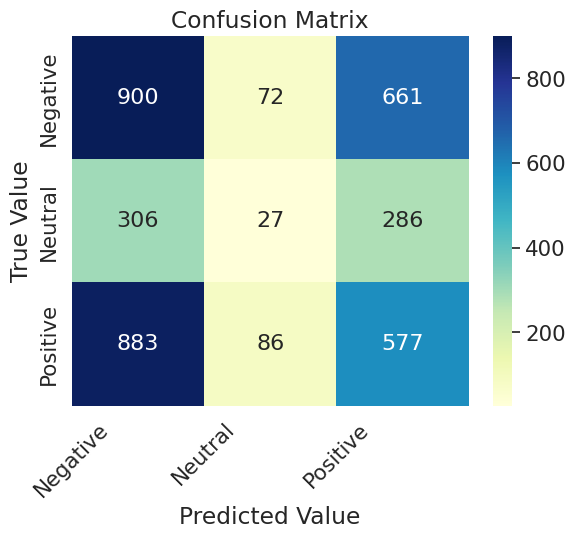

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
labels_3 = ['Negative','Neutral','Positive']

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]),
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()

print_cf1(y_test, y_test_pred)

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.43      0.55      0.48      1633
     Neutral       0.15      0.04      0.07       619
    Positive       0.38      0.37      0.38      1546

    accuracy                           0.40      3798
   macro avg       0.32      0.32      0.31      3798
weighted avg       0.36      0.40      0.37      3798



**Hyper Parameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'alpha': [0.01,0.15,0.1,0.05,0.5,1,10],
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(x_train_data, y_train)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(x_train_data, y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(x_test_data, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Train Accuracy : 0.709
Test Accuracy : 0.410
Best Accuracy Through Grid Search : 0.669
Best Parameters :  {'alpha': 0.1}


After performing Hyperparameter Tuning we observed that the test accuracy and training accuracy has been increased to 41% and 70.9% respectively

#Gradient Boosting Classifier


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gboost_m = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
train_pred = gboost_m.fit(x_train_data, y_train).predict(x_train_data)
prediction = gboost_m.score(x_test_data, y_test)
print("Gradient Boosting model train accuracy( in % ): ",accuracy_score(y_train, train_pred)*100 )
print("Gradient Boosting model test accuracy( in % ): ", prediction*100)

Gradient Boosting model train accuracy( in % ):  72.74825667565663
Gradient Boosting model test accuracy( in % ):  41.99578725645076


#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier()
train_pred = rf_model.fit(x_train_data, y_train).predict(x_train_data)
prediction = rf_model.score(x_test_data, y_test)
print("Random Forest model train accuracy( in % ): ",metrics.accuracy_score(y_train, train_pred)*100 )
print("random Forest model test accuracy( in % ): ", prediction*100)

Random Forest model train accuracy( in % ):  99.79590349150813
random Forest model test accuracy( in % ):  40.15271195365982


We can observe that the model overfits the training data and performs weakly on the test data. We need to perform hyperparameter tuning to not overfit the training data.

In [ ]:
rf_model=RandomForestClassifier(n_estimators=300,min_samples_split = 10,min_samples_leaf = 8)
train_pred = rf_model.fit(x_train_data,y_train).predict(x_train_data)
prediction = rf_model.score(x_test_data, y_test )
print("Random Forest model train accuracy( in % ): ",metrics.accuracy_score(y_train, train_pred)*100 )
print("Random Forest model test accuracy( in % ): ", prediction*100)

Random Forest model train accuracy( in % ):  77.420608887917
Random Forest model test accuracy( in % ):  35.518694049499736


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
max_depth = [1,2,5,10]
min_samples_split = [5,10,15]
min_samples_leaf = [1, 2,5, 10]
random_grid = {

               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(x_train_data,y_train)
print(rf_randomcv.best_params_)
print(rf_randomcv)
#print(rf_randomcv.best_estimator_)
best_random_grid=rf_randomcv.best_estimator_
print(best_random_grid)

{'max_depth': [1, 2, 5, 10], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10], 'criterion': ['entropy', 'gini']}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy'}
RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 2, 5, 10],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [5, 10, 15]},
                   random_state=100, verbose=2)
RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=10)


In [ ]:
# Training Random Forest with best accuaracy parameters
rf_model_hp=RandomForestClassifier(n_estimators=300,min_samples_split = 10,min_samples_leaf = 5, criterion='entropy', max_depth=10)
train_pred = rf_model_hp.fit(x_train_data,y_train).predict(x_train_data)
prediction = rf_model_hp.score(x_test_data, y_test)
print("Random Forest model train accuracy with best hyperparameters( in % ): ",metrics.accuracy_score(y_train, train_pred)*100 )
print("Random Forest model test accuracywith best hyperparameters ( in % ): ", prediction*100)

Random Forest model train accuracy with best hyperparameters( in % ):  56.72425103870544
Random Forest model test accuracywith best hyperparameters ( in % ):  41.363875724065295


Now the model didn't overfit the training data as we performed cross validation and choosed the best parameters.

The accuracy of Random Forest is better than the Naive Bayes and Gradient Boosting Classifier

**Observations**
*   We observed that the test accuracy is way low around 42%. We need to consider better algorithm for higher test accuracy.
*   The sequence of words plays a key role and we need a model like RNN or LSTM that considers sequential data.
*   We need to be able to keep track of each word and when it occurs in the data.
*   We lose insights about the data if we just encode the input and it would be difficult to get meaningful insights about the data





# RNN Model

In [ ]:
print("X_train\n",x_train.head())
print("Y_train\n",y_train.head())

print("X_test\n",x_test.head())
print("Y_test\n",y_test.head())

X_train
 0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock not one empty please dont panic eno...
4    ready go supermarket covid outbreak not im par...
Name: CleanedTweet, dtype: object
Y_train
 0    1
1    2
2    2
3    2
4    0
Name: Sentiment_label, dtype: int64
X_test
 0    trending new yorkers encounter empty supermark...
1    couldnt find hand sanitizer fred meyer turned ...
2                   find protect loved one coronavirus
3    panic buying hit newyork city anxious shopper ...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: CleanedTweet, dtype: object
Y_test
 0    0
1    2
2    2
3    0
4    1
Name: Sentiment_label, dtype: int64


**Tokenisation, Sequencing and Padding**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=50000,
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [ ]:
tokenizer.fit_on_texts(x_train)
wordindex=tokenizer.word_index

In [ ]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()
#tokenizer_config['word_counts']

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [ ]:
import tensorflow.keras.preprocessing.sequence as ps

In [ ]:
max_length = 50
train_sequence = tokenizer.texts_to_sequences(x_train)
train_padding = ps.pad_sequences(train_sequence,maxlen=max_length,padding='post')

test_sequence = tokenizer.texts_to_sequences(x_test)
test_padding = ps.pad_sequences(test_sequence,maxlen=max_length,padding='post')


In [ ]:
train_padding.shape


(41157, 50)

In [ ]:
y_train.head()

0    1
1    2
2    2
3    2
4    0
Name: Sentiment_label, dtype: int64

In [ ]:
y_train.values.reshape(-1,1)
y_train.shape

(41157,)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
y_train = OneHotEncoder().fit_transform(y_train.values.reshape(-1,1))

In [ ]:
y_test = OneHotEncoder().fit_transform(y_test.values.reshape(-1,1))
y_test.shape

(3798, 3)

In [ ]:
y_train.shape

(41157, 3)

**Building the model**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout, Bidirectional

from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D

In [ ]:
# Building the BASELINE MODEL
base_model = Sequential()
base_model.add(Embedding(50000,128,input_length=train_padding.shape[1]))
base_model.add(GlobalAveragePooling1D())
base_model.add(Dense(8,activation='relu'))
base_model.add(Dense(3,activation='softmax'))

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 6401059 (24.42 MB)
Trainable params: 6401059 (24.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Compiling the model

base_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
y_train=np.array(y_train.toarray())

In [ ]:
train_padding=np.array(train_padding)

In [ ]:
#Fitting the model

rnn_model_history = base_model.fit(train_padding,y_train ,epochs=10, validation_split=0.2)

Epoch 1/10
1029/1029 [==============================] - 27s 21ms/step - loss: 0.8444 - accuracy: 0.6108 - val_loss: 0.6593 - val_accuracy: 0.7439
Epoch 2/10
1029/1029 [==============================] - 9s 8ms/step - loss: 0.5056 - accuracy: 0.8289 - val_loss: 0.5527 - val_accuracy: 0.8032
Epoch 3/10
1029/1029 [==============================] - 7s 7ms/step - loss: 0.3349 - accuracy: 0.8979 - val_loss: 0.5955 - val_accuracy: 0.7862
Epoch 4/10
1029/1029 [==============================] - 8s 8ms/step - loss: 0.2445 - accuracy: 0.9297 - val_loss: 0.6246 - val_accuracy: 0.7930
Epoch 5/10
1029/1029 [==============================] - 6s 6ms/step - loss: 0.1911 - accuracy: 0.9457 - val_loss: 0.7218 - val_accuracy: 0.7771
Epoch 6/10
1029/1029 [==============================] - 7s 7ms/step - loss: 0.1507 - accuracy: 0.9584 - val_loss: 0.8005 - val_accuracy: 0.7710
Epoch 7/10
1029/1029 [==============================] - 8s 7ms/step - loss: 0.1216 - accuracy: 0.9650 - val_loss: 0.8769 - val_accurac

Lowest Validation Loss: epoch 2
Highest Validation Accuracy: epoch 2


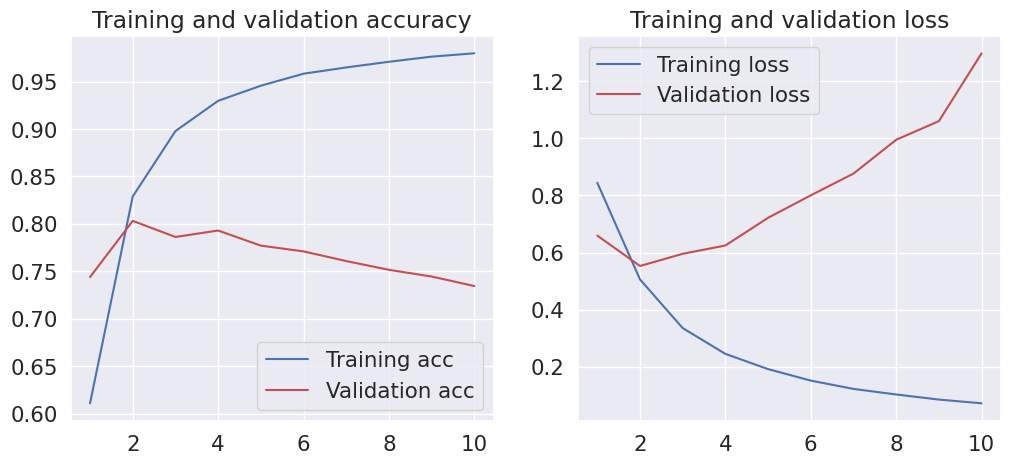

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(rnn_model_history)



> One observation is that the model performs well on the training data but the validation accuracy of the model is low. The model has been overfit for the data. We need to regularise the model




In [ ]:
regularise = tensorflow.keras.regularizers.l2(0.001)

model_rnn = Sequential()
model_rnn.add(Embedding(50000,128,input_length=train_padding.shape[1]))
model_rnn.add(Dropout(0.5))
model_rnn.add(GlobalAveragePooling1D())
model_rnn.add(Dense(8,activation='relu',kernel_regularizer=regularise))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(3,activation='softmax'))
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                      

In [ ]:
#Compiling the model
model_rnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#Fitting the model
history_rnn = model_rnn.fit(train_padding,y_train ,epochs=10, validation_split=0.2)

Epoch 1/10
1029/1029 [==============================] - 26s 23ms/step - loss: 0.9974 - accuracy: 0.5008 - val_loss: 0.8813 - val_accuracy: 0.6527
Epoch 2/10
1029/1029 [==============================] - 8s 7ms/step - loss: 0.8477 - accuracy: 0.6062 - val_loss: 0.7591 - val_accuracy: 0.6910
Epoch 3/10
1029/1029 [==============================] - 8s 7ms/step - loss: 0.7633 - accuracy: 0.6408 - val_loss: 0.6982 - val_accuracy: 0.6989
Epoch 4/10
1029/1029 [==============================] - 7s 6ms/step - loss: 0.7071 - accuracy: 0.6573 - val_loss: 0.6587 - val_accuracy: 0.7550
Epoch 5/10
1029/1029 [==============================] - 8s 7ms/step - loss: 0.6753 - accuracy: 0.6809 - val_loss: 0.6422 - val_accuracy: 0.7602
Epoch 6/10
1029/1029 [==============================] - 7s 7ms/step - loss: 0.6481 - accuracy: 0.6992 - val_loss: 0.6305 - val_accuracy: 0.7764
Epoch 7/10
1029/1029 [==============================] - 6s 6ms/step - loss: 0.6236 - accuracy: 0.7088 - val_loss: 0.6297 - val_accurac

Lowest Validation Loss: epoch 9
Highest Validation Accuracy: epoch 7


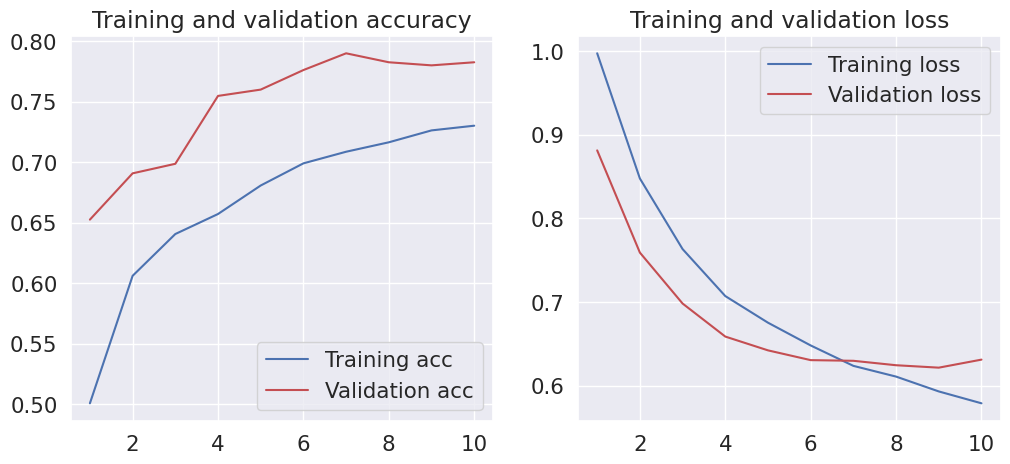

In [ ]:
plot_history(history_rnn)

In [ ]:
score = model_rnn.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

119/119 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.7780
Testing Accuracy(%):  77.80410647392273


In [ ]:
y_pred = model_rnn.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

119/119 [==============================] - 0s 2ms/step


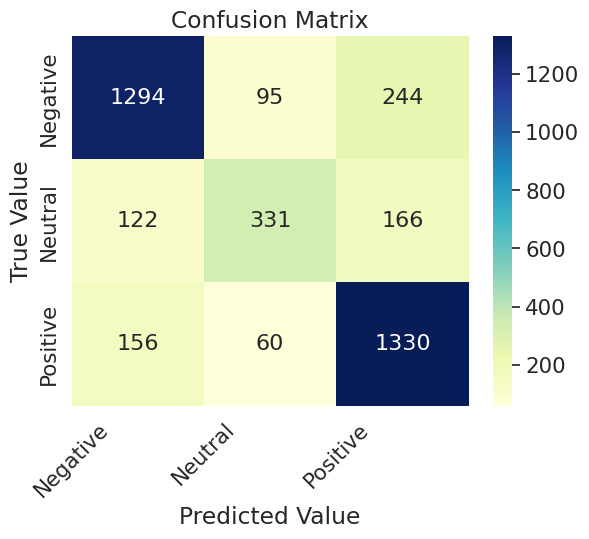

In [ ]:
#Plotting Confusion matrix
print_cf1(y_test_labels, y_predicted_labels)

**Observations**


* We observed from the Training and Validation plots that the model is not overfit.
* The test accuracy has been increased way more from 43% in the baseline models to 77.89% in the RNN models. The increase in accuracy is mainly attributed to storing the sequential data in the RNN.



# LSTM models

In [ ]:
from keras.constraints import max_norm

In [ ]:
#Building the model
lstm_model = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Dropout(0.5),
    LSTM(32,kernel_constraint=max_norm(3)),
    Dense(32,activation='relu',kernel_regularizer=regularise),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           6400000   
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6421763 (24.50 MB)
Trainable params: 642

In [ ]:
#Compiling the model
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
lstm_history =  lstm_model.fit(train_padding,y_train ,epochs=8, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/8
1029/1029 [==============================] - 31s 24ms/step - loss: 1.0227 - accuracy: 0.4592 - val_loss: 0.8751 - val_accuracy: 0.5753
Epoch 2/8
1029/1029 [==============================] - 11s 11ms/step - loss: 0.8156 - accuracy: 0.6508 - val_loss: 0.6938 - val_accuracy: 0.7330
Epoch 3/8
1029/1029 [==============================] - 9s 8ms/step - loss: 0.6369 - accuracy: 0.7747 - val_loss: 0.5941 - val_accuracy: 0.7914
Epoch 4/8
1029/1029 [==============================] - 10s 10ms/step - loss: 0.5699 - accuracy: 0.7980 - val_loss: 0.6005 - val_accuracy: 0.7829
Epoch 5/8
1029/1029 [==============================] - 9s 9ms/step - loss: 0.4536 - accuracy: 0.8555 - val_loss: 0.5800 - val_accuracy: 0.8123
Epoch 6/8
1029/1029 [==============================] - 10s 10ms/step - loss: 0.3795 - accuracy: 0.8834 - val_loss: 0.5829 - val_accuracy: 0.8113
Epoch 7/8
1029/1029 [==============================] - 11s 10ms/step - loss: 0.3376 - accuracy: 0.8970 - val_loss: 0.5925 - val_accura

Lowest Validation Loss: epoch 5
Highest Validation Accuracy: epoch 5


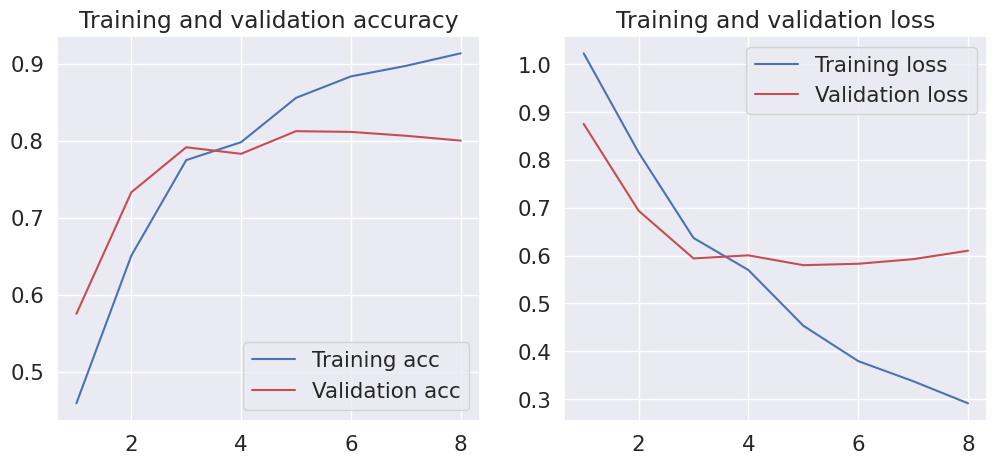

In [ ]:
plot_history(lstm_history)

In [ ]:
score = lstm_model.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

119/119 [==============================] - 1s 4ms/step - loss: 0.6570 - accuracy: 0.7870
Testing Accuracy(%):  78.6993145942688


In [ ]:
y_pred = lstm_model.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

119/119 [==============================] - 1s 3ms/step


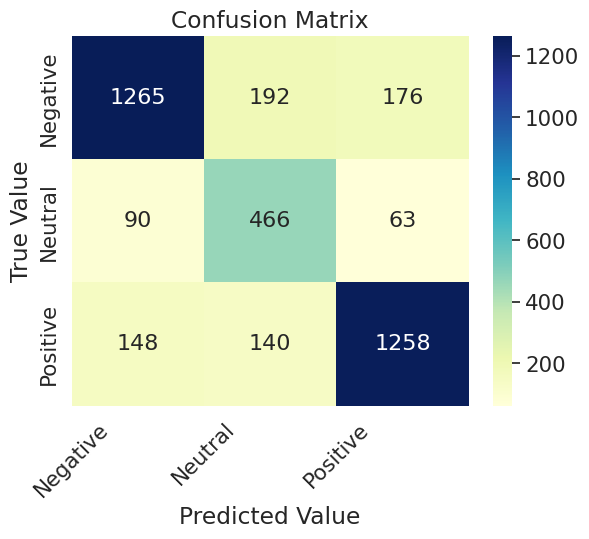

In [ ]:
#Plotting Confusion matrix
print_cf1(y_test_labels, y_predicted_labels)

In [ ]:
print(classification_report(y_test_labels, y_predicted_labels, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.84      0.77      0.81      1633
     Neutral       0.58      0.75      0.66       619
    Positive       0.84      0.81      0.83      1546

    accuracy                           0.79      3798
   macro avg       0.76      0.78      0.76      3798
weighted avg       0.80      0.79      0.79      3798



**Observations**
* We can observe that the test accuracy of LSTM models is around 79% which is better than RNN models which are around 76%.
* It is mainly due to the fact that for simple RNN layer, input from previous timestamps gradually disappeared as we got further through the input. With a LSTM we have a long-term memory data structure storing all the previously seen inputs as well as when we saw them.
* This allows for us to access any previous value we want at any point in time. This adds to the complexity of our network and allows it to discover more useful relationships between inputs and when they appear.

However we can see that there is wide gap in training and validation accuracy. So we try to perform hyperparameter tuning and regularisation to decrease overfitting

# Bi Directional LSTM

In [ ]:
#Building the model
lstm_model_2 = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
#Compiling the model
lstm_model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
lstm_history_2 =  lstm_model_2.fit(train_padding,y_train ,epochs=8, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/8
1029/1029 [==============================] - 43s 34ms/step - loss: 0.7015 - accuracy: 0.7117 - val_loss: 0.4517 - val_accuracy: 0.8393
Epoch 2/8
1029/1029 [==============================] - 20s 19ms/step - loss: 0.3730 - accuracy: 0.8806 - val_loss: 0.4662 - val_accuracy: 0.8343
Epoch 3/8
1029/1029 [==============================] - 18s 18ms/step - loss: 0.2316 - accuracy: 0.9268 - val_loss: 0.5625 - val_accuracy: 0.8347
Epoch 4/8
1029/1029 [==============================] - 19s 19ms/step - loss: 0.1516 - accuracy: 0.9528 - val_loss: 0.7376 - val_accuracy: 0.8208


Lowest Validation Loss: epoch 1
Highest Validation Accuracy: epoch 1


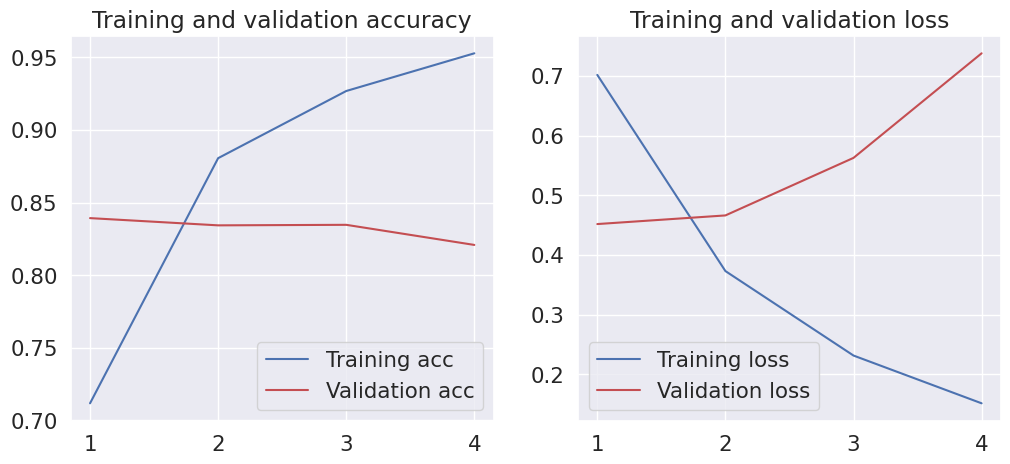

In [ ]:
plot_history(lstm_history_2)

In [ ]:
score = lstm_model_2.evaluate(test_padding,y_test.toarray())
print("Testing Accuracy(%): ", score[1]*100)

119/119 [==============================] - 1s 8ms/step - loss: 0.7030 - accuracy: 0.8141
Testing Accuracy(%):  81.4112663269043


In [ ]:
y_pred = lstm_model_2.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])

119/119 [==============================] - 2s 6ms/step


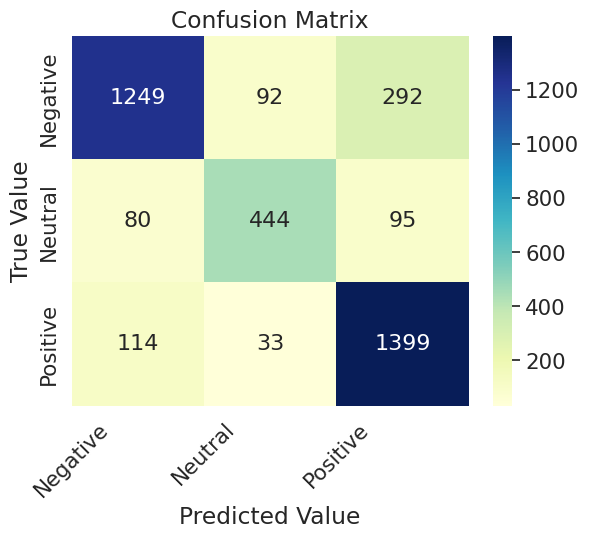

In [ ]:
#Plotting Confusion matrix
print_cf1(y_test_labels, y_predicted_labels)

In [ ]:
print(classification_report(y_test_labels, y_predicted_labels, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.87      0.76      0.81      1633
     Neutral       0.78      0.72      0.75       619
    Positive       0.78      0.90      0.84      1546

    accuracy                           0.81      3798
   macro avg       0.81      0.80      0.80      3798
weighted avg       0.82      0.81      0.81      3798



We can observe that the accuracy of Bidirectional LSTMs are slightly better than the LSTM models

# DistilBERT

Tokenising the inputs

In [ ]:
MODEL_NAME = 'distilbert-base-cased'

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
max_val = 0
for eachSent in (x_train.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(eachSent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass

print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 103


I will set the max length and input for the deep learning model to 105  
*(Max token length + 2 for special characters [CLS] and [SEP])*

In [ ]:
MAX_LENGTH = 105

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH,
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=True,
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)

100%|██████████| 3798/3798 [00:01<00:00, 2064.28it/s]


**Looking at the entries**

In [ ]:
index_num = 5

print(train_df.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for each in range(len(temp_ids)):
    if each == 0:
        print(temp_ids[each], '[CLS]', sep='\t')
        continue
    if each == len(temp_ids)-1:
        print(temp_ids[each], '[SEP]', sep='\t')
        break
    print(temp_ids[each], temp_tokens[each-1], sep='\t')

Positive 

news region first confirmed covid case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good report 

ID's	Input Tokens
101	[CLS]
2371	news
1805	region
1148	first
3659	confirmed
1884	co
18312	##vid
1692	case
1338	came
28117	su
6473	##lli
5242	##van
2514	county
1314	last
1989	week
1234	people
24117	flock
1174	##ed
1298	area
2984	store
4779	purchase
9374	cleaning
3880	supply
1289	hand
21718	sa
2605	##ni
3121	##ti
6198	##zer
2094	food
12356	toilet
2526	paper
1363	good
2592	report
102	[SEP]


In [ ]:

config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
attention_mask_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32')

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = attention_mask_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

distil_bert_model = tf.keras.Model(inputs=[input_ids_in, attention_mask_in], outputs = X)

for eachLayer in distil_bert_model.layers[:3]:
    eachLayer.trainable = False
distil_bert_model.summary()

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 105)]                0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 105)]                0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6519091   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 105, 768)   2          'masked_token[0][0]']        
                             , hidden_states=((None, 10                                           
                             5, 768),                                                         

In [ ]:
### Create an output directory
output_dir = './model2_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

In [ ]:
reduce_lr =    ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
y_train.shape

(41157, 3)

In [ ]:
distil_bert_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = distil_bert_model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[model_checkpoint, EarlyStopping(monitor='val_loss',patience=3),reduce_lr])

Epoch 1/10
2058/2058 [==============================] - 232s 100ms/step - loss: 0.7805 - accuracy: 0.6575 - val_loss: 0.6633 - val_accuracy: 0.7269 - lr: 0.0010
Epoch 2/10
2058/2058 [==============================] - 205s 100ms/step - loss: 0.6563 - accuracy: 0.7289 - val_loss: 0.6286 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 3/10
2058/2058 [==============================] - 198s 96ms/step - loss: 0.6013 - accuracy: 0.7584 - val_loss: 0.5930 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 4/10
2058/2058 [==============================] - 205s 100ms/step - loss: 0.5577 - accuracy: 0.7799 - val_loss: 0.5821 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 5/10
2058/2058 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7995
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2058/2058 [==============================] - 205s 99ms/step - loss: 0.5154 - accuracy: 0.7995 - val_loss: 0.5837 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 6/10
2058/2058 [===========

**Plotting Training and Validation accuracy**

Lowest Validation Loss: epoch 6
Highest Validation Accuracy: epoch 6


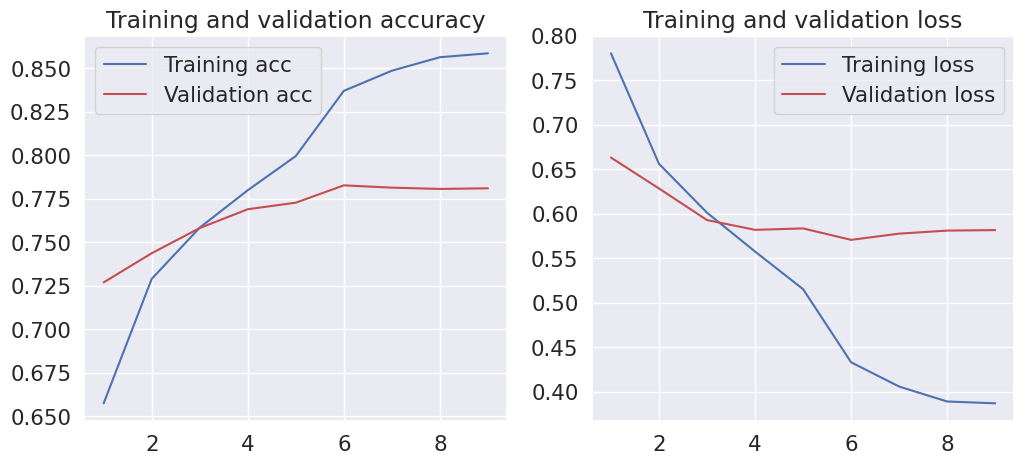

In [ ]:
plot_history(history)

Loading the models with best validation accuracy

In [ ]:
def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
distil_bert_model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Testing on Test Data**

In [ ]:
y_test_probs = distil_bert_model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

119/119 [==============================] - 20s 116ms/step


**Results**

In [ ]:
labels_3 = ['Negative','Neutral','Positive']
def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]),
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()

Accuracy: 0.765666140073723


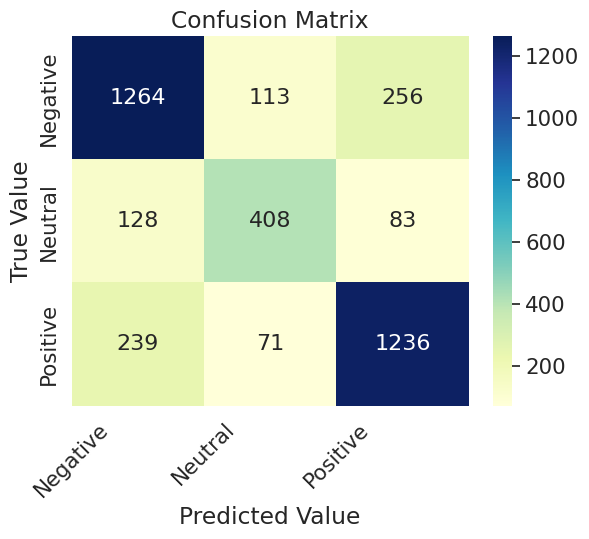

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [ ]:
print(classification_report(y_test, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.77      0.77      0.77      1633
     Neutral       0.69      0.66      0.67       619
    Positive       0.78      0.80      0.79      1546

    accuracy                           0.77      3798
   macro avg       0.75      0.74      0.75      3798
weighted avg       0.76      0.77      0.77      3798

